### Load Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

### Load Data

In [2]:
DATA_DIR = "data"
filename = "COPD_data.csv"

In [3]:
def load_data(DATA_DIR, filename):
    """
    Returns a dataframe from the specified file location
    """
    filepath = os.path.join(DATA_DIR, filename)
    df = pd.read_csv(filepath)
    df.dropna(axis=0, inplace=True)
    
    return df

df = load_data(DATA_DIR, filename)
df.head()

,Unnamed: 0,ID,AGE,PackHistory,COPDSEVERITY,MWT1,MWT2,MWT1Best,FEV1,FEV1PRED,...,SGRQ,AGEquartiles,copd,gender,smoking,Diabetes,muscular,hypertension,AtrialFib,IHD
0,1,58,77,60.0,SEVERE,120.0,120.0,120.0,1.21,36.0,...,69.55,4,3,1,2,1,0,0,1,0
1,2,57,79,50.0,MODERATE,165.0,176.0,176.0,1.09,56.0,...,44.24,4,2,0,2,1,0,0,1,1
2,3,62,80,11.0,MODERATE,201.0,180.0,201.0,1.52,68.0,...,44.09,4,2,0,2,1,0,0,1,0
3,4,145,56,60.0,VERY SEVERE,210.0,210.0,210.0,0.47,14.0,...,62.04,1,4,1,2,0,0,1,1,0
4,5,136,65,68.0,SEVERE,204.0,210.0,210.0,1.07,42.0,...,75.56,1,3,1,2,0,1,1,0,0


In [4]:
# There are several ID's that are duplicated but have (mostly) different values for remaining features
num_dup = df[df.duplicated(subset="ID")].shape[0] - df[df.duplicated()].shape[0]
print("Number of duplicate IDs:", num_dup)

Number of duplicate IDs: 4


In [5]:
# Show rows with duplicated IDS
df[df.duplicated(subset=["ID"])]

,Unnamed: 0,ID,AGE,PackHistory,COPDSEVERITY,MWT1,MWT2,MWT1Best,FEV1,FEV1PRED,...,SGRQ,AGEquartiles,copd,gender,smoking,Diabetes,muscular,hypertension,AtrialFib,IHD
15,16,162,71,105.0,MODERATE,264.0,271.0,271.0,0.72,52.0,...,39.66,2,2,0,2,0,0,0,0,0
61,62,159,81,3.0,MILD,435.0,451.0,451.0,1.83,90.0,...,36.74,4,1,1,2,1,1,0,0,0
70,71,158,70,36.0,MILD,419.0,459.0,459.0,1.89,90.0,...,10.92,2,1,0,2,0,0,0,0,0
77,78,157,76,30.0,MODERATE,469.0,399.0,469.0,1.74,59.0,...,32.38,4,2,1,1,0,0,0,0,0


In [6]:
# Drop columns with uninformative features
df.drop(["Unnamed: 0"], axis=1, inplace=True)
df.columns

Index(['ID', 'AGE', 'PackHistory', 'COPDSEVERITY', 'MWT1', 'MWT2', 'MWT1Best',
       'FEV1', 'FEV1PRED', 'FVC', 'FVCPRED', 'CAT', 'HAD', 'SGRQ',
       'AGEquartiles', 'copd', 'gender', 'smoking', 'Diabetes', 'muscular',
       'hypertension', 'AtrialFib', 'IHD'],
      dtype='object')

### Objective  
The objective of this study is to investigate whether certain features are associated with quality of life.

### Description of Data Set and Features  
The dataset is a cohort of patients (n = 101), who had been invited to take part in a rehabilitation program to help manage their chronic obstructive pulmonary disease (COPD). Variables in the dataset describe characteristics of the patients (age, sex, smoking or not and pack history), disease (COPD), walking ability (MWT1, MWT2), lung function (e.g. FEV) as well as information on whether individuals experienced anxiety and depression and several comorbidities. The outcome variable is quality of life (`SGRQ`) with higher scores indicating *more* limitations. An alternative outcome variable is mean walking distance (`MWT1Best`).  

The St. George's Respiratory Questionnaire (SGRQ) is a disease-specific instrument designed to measure impact on overall health, daily life, and perceived well-being in patients with obstructive airways disease (https://www.thoracic.org/members/assemblies/assemblies/srn/questionaires/sgrq.php).

### Exploratory Data Analysis  

Determine which features are binary, categorical (non-binary) or continuous:

In [7]:
bin_vars = []
cat_vars = []
cont_vars = []
for column in df.columns:
    if df[column].nunique() < 3:
        bin_vars.append(column)
    elif df[column].nunique() < 10:
        cat_vars.append(column)
    else:
        cont_vars.append(column)
        
print("Binary features:", bin_vars)
print("Categorical features:", cat_vars)
print("Continuous features:", cont_vars)

Binary features: ['gender', 'smoking', 'Diabetes', 'muscular', 'hypertension', 'AtrialFib', 'IHD']
Categorical features: ['COPDSEVERITY', 'AGEquartiles', 'copd']
Continuous features: ['ID', 'AGE', 'PackHistory', 'MWT1', 'MWT2', 'MWT1Best', 'FEV1', 'FEV1PRED', 'FVC', 'FVCPRED', 'CAT', 'HAD', 'SGRQ']


In [8]:
print("Shape of dataframe:", df.shape)
df.head()

Shape of dataframe: (99, 23)


,ID,AGE,PackHistory,COPDSEVERITY,MWT1,MWT2,MWT1Best,FEV1,FEV1PRED,FVC,...,SGRQ,AGEquartiles,copd,gender,smoking,Diabetes,muscular,hypertension,AtrialFib,IHD
0,58,77,60.0,SEVERE,120.0,120.0,120.0,1.21,36.0,2.40,...,69.55,4,3,1,2,1,0,0,1,0
1,57,79,50.0,MODERATE,165.0,176.0,176.0,1.09,56.0,1.64,...,44.24,4,2,0,2,1,0,0,1,1
2,62,80,11.0,MODERATE,201.0,180.0,201.0,1.52,68.0,2.30,...,44.09,4,2,0,2,1,0,0,1,0
3,145,56,60.0,VERY SEVERE,210.0,210.0,210.0,0.47,14.0,1.14,...,62.04,1,4,1,2,0,0,1,1,0
4,136,65,68.0,SEVERE,204.0,210.0,210.0,1.07,42.0,2.91,...,75.56,1,3,1,2,0,1,1,0,0


Plot a distribution of the target variable `SGRQ`.

NB: It is not necessary for linear regression that the target variable is normally distributed.

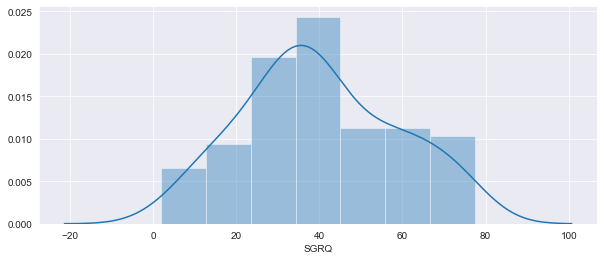

In [9]:
plt.figure(figsize=(10,4))
sns.distplot(df['SGRQ']);

Display relationship between `FEV1` and `MWT1Best`.

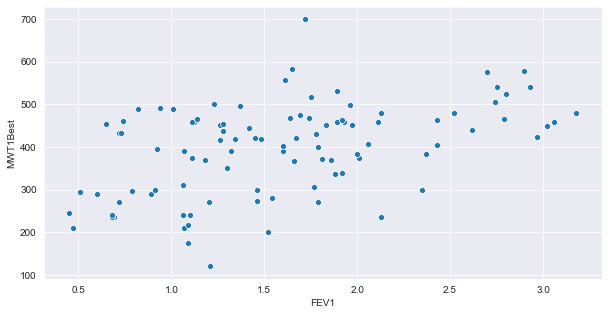

In [10]:
plt.figure(figsize=(10,5))
sns.scatterplot('FEV1', 'MWT1Best', data=df);

Display relationship between `AGE` and `MWT1Best`.

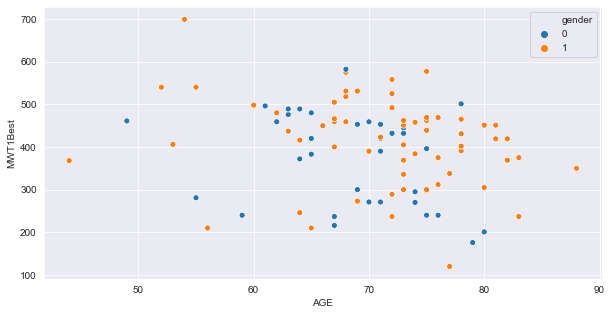

In [11]:
plt.figure(figsize=(10,5))
sns.scatterplot('AGE', 'MWT1Best', hue='gender', data=df);

Display a correlation matrix and a pairplot for selected continuous variables.  

There is no apparent strong colinearity between most features. Note that some features such `MWT1` are strongly correlated with other features such as `MWT2`.

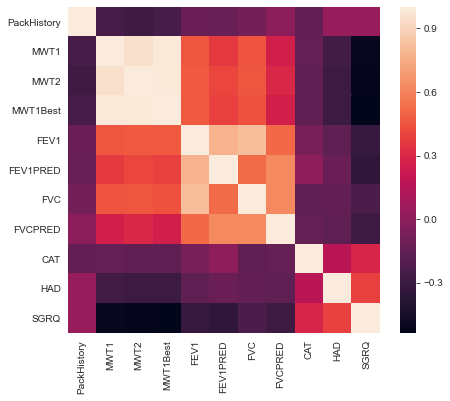

In [12]:
plt.figure(figsize=(7,6))
sns.heatmap(df[cont_vars[2:]].corr());

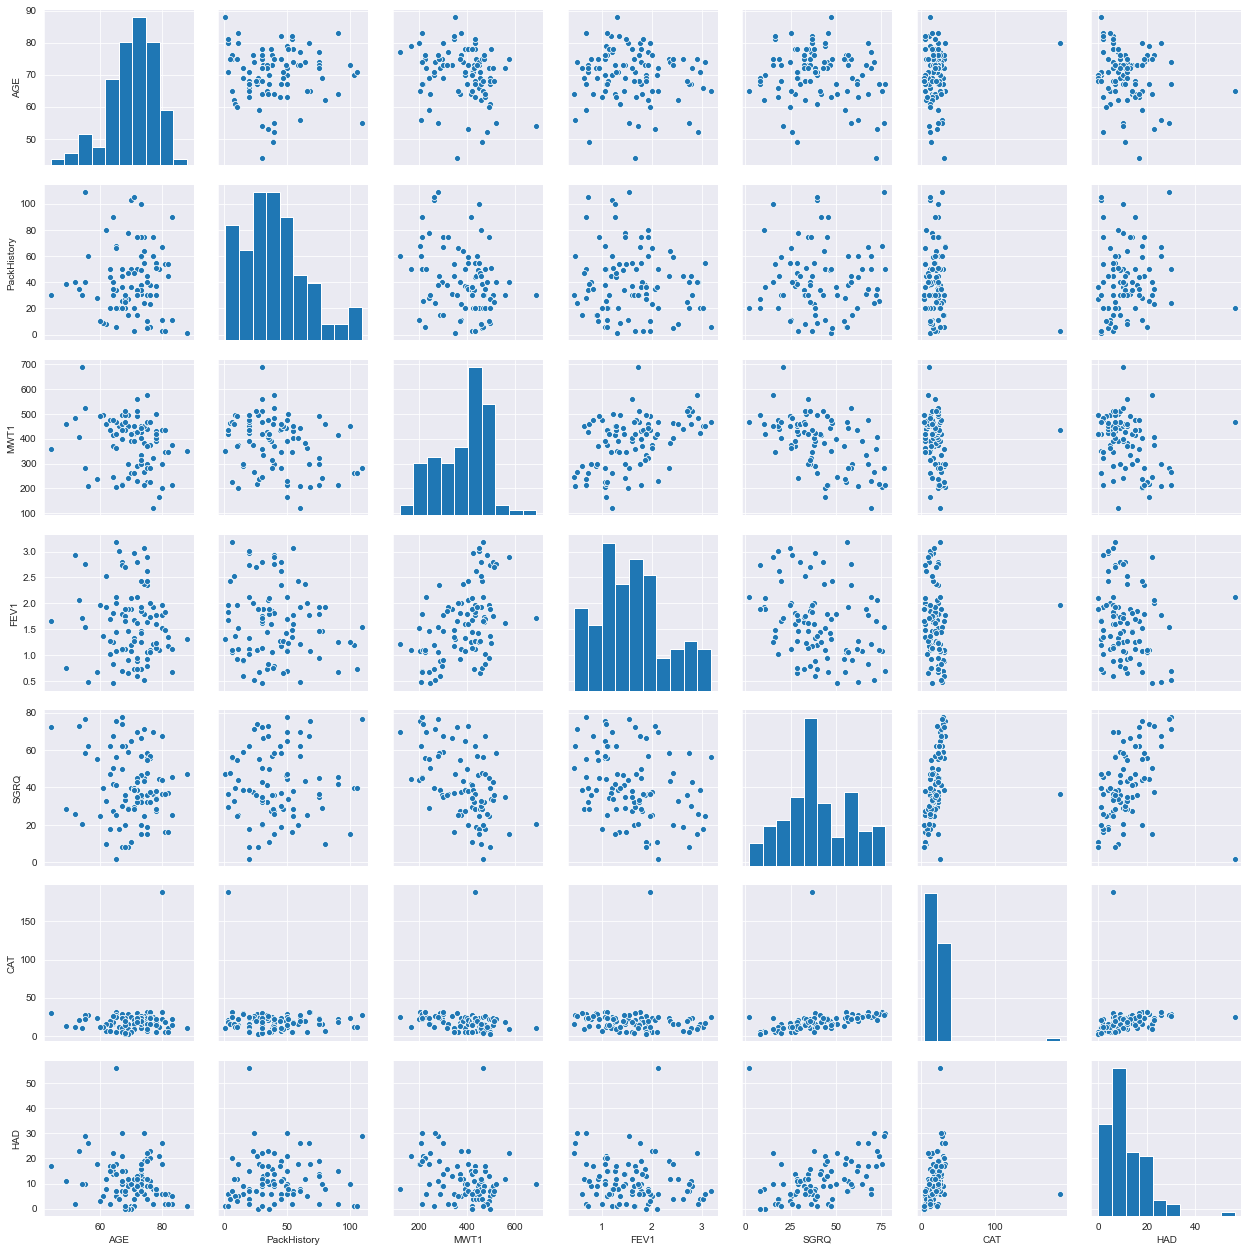

In [13]:
sns.pairplot(df[['AGE', 'PackHistory', 'MWT1', 'FEV1', 'SGRQ', 'CAT', 'HAD']]);

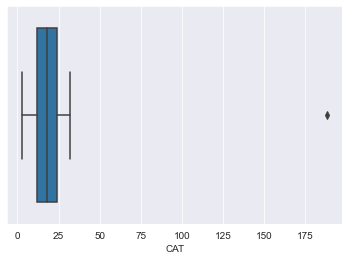

In [14]:
# Display a boxplot for CAT which seems to have an outlier
sns.boxplot(df['CAT']);

Display barplot for binary and non-binary, categorical variables.

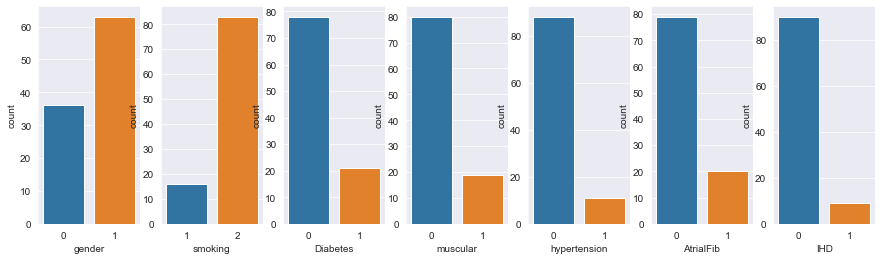

In [15]:
plt.figure(figsize=(15,4))
for i in range(1,len(bin_vars)+1):
    plt.subplot(1,len(bin_vars),i)
    sns.countplot(df[bin_vars[i-1]]);

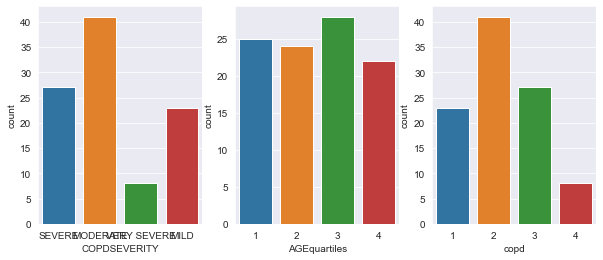

In [16]:
plt.figure(figsize=(10,4))
for i in range(1,len(cat_vars)+1):
    plt.subplot(1,len(cat_vars),i)
    sns.countplot(df[cat_vars[i-1]]);

### **Feature Engineering**

In [17]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures

In [18]:
# Recode smoking: 1 <- 0, 1 <-2
df["smoking"] = df["smoking"].replace({1:0, 2:1})
# Change type of selected categorical variables to object (string)
df["AGEquartiles"] = df["AGEquartiles"].astype(str)
df["copd"] = df["copd"].astype(str)

Values for the COPD Assessment Test (`CAT`) can take on values from 0 to 40. The single, extreme outlier of 188 is probably a data entry error.

In [19]:
df["CAT"].replace({188:18}, inplace=True)

Helper function to add polynomial features.

In [20]:
def add_poly(df, features, degree, interaction_only):
    """
    Adds polynomial features to a set of variables
    Inputs:
        df, dataframe
        features, list of features used for adding polynomial features
        degree, degree of polynomials to be added
        interaction_only, specifies whether to add only interaction terms
    Output:
        A dataframe with the polynomial features added
    """
    df_copy = df.copy()
    pf = PolynomialFeatures(degree=degree, interaction_only=interaction_only, include_bias=False)
    res = pf.fit_transform(df_copy[features])
    X_poly = pd.DataFrame(res, columns=pf.get_feature_names(features))
    X_poly.drop(features, axis=1, inplace=True)
    # reset indices to prevent NaNs being introduced
    df_res = pd.concat([df_copy.reset_index(drop=True), X_poly.reset_index(drop=True)], axis=1)
    df_res.columns = df_res.columns.str.replace(" ", "*")
    return df_res

df_poly = add_poly(df, ["AGE", "FEV1"], 2, True)

Helper function to onehot encode a categorical column

In [21]:
# Encode categorical, non-binary features
def encode_cat(df, cols):
    """
    """
    data_ohc = df.copy()
    
    le = LabelEncoder()
    ohc = OneHotEncoder(drop="first")
    
    for col in cols:
        # Integer encode the string categories
        dat = le.fit_transform(data_ohc[col]).astype(np.int)
        # Remove the original column from the dataframe
        data_ohc = data_ohc.drop(col, axis=1)
        # One hot encode the data--this returns a sparse array
        new_dat = ohc.fit_transform(dat.reshape(-1,1))
        # Create unique column names
        n_cols = new_dat.shape[1]
        col_names = ['_'.join([col, str(x)]) for x in range(1, n_cols+1)]
        # Create the new dataframe
        new_df = pd.DataFrame(new_dat.toarray(), 
                              index=data_ohc.index, 
                              columns=col_names)
        # Append the new data to the dataframe
        data_ohc = pd.concat([data_ohc, new_df], axis=1)
    
    return data_ohc
        
df_ohc = encode_cat(df, cat_vars)

### **Basic Linear Regression**

In [22]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [23]:
from scipy.stats.mstats import normaltest
from scipy.stats import boxcox, pearsonr
from sklearn.metrics import r2_score
from scipy.special import inv_boxcox

Confirm that the target variables (`SGRQ` or `MWT1Best`) are (approximately) normally distributed.

In [24]:
print("Untransformed:", normaltest(df['SGRQ'].values))
print("Untransformed:", normaltest(df['MWT1Best'].values))

Untransformed: NormaltestResult(statistic=4.1065856448047855, pvalue=0.1283116995635351)
Untransformed: NormaltestResult(statistic=1.4034073235804363, pvalue=0.4957400106350349)


##### Example with a Single Continuous Predictor

In [25]:
def lin_reg(df, predictors, target, poly=False, interaction_only=True):
    """
    Perform a basic linear regression with or without polynomial features
    """
    df_copy = df.copy()
    lr = LinearRegression()
    X = df_copy[predictors]
    y = df_copy[target]
    
    if poly == True:
        pf = PolynomialFeatures(degree=2, interaction_only=interaction_only, include_bias=False)
        X = pf.fit_transform(X)
    
    lr.fit(X, y)
    r2 = lr.score(X,y)
    return r2, lr.intercept_, lr.coef_

Compare R-squared without and with polynomial features.  

The results show that the formula for the outcome `SGRQ` ($\hat y$), using `FEV1` as the predictor is: $ \hat y = 53.87 -8.55x_{1}$ or, in other words, for each unit increase in `FEV1`, the quality of life score decreases by 8.55. Note that `FEV1` only explains about 10% of the variability in `SGRQ`. The addition of a polynomial feature does not greatly alter the variability explained by the predictor(s) and may serve to make the model too complex in this instance. 

In [26]:
r2, intercept, coefficients = lin_reg(df, ['FEV1'], ['SGRQ'], poly=False)
print("R squared with no poly:", round(r2,3))
print("Intercept:", intercept)
print("Coefficients:", coefficients)
r2, intercept, coefficients = lin_reg(df, ['FEV1'], ['SGRQ'], poly=True)
print("R squared with poly:", round(r2,3))

R squared with no poly: 0.099
Intercept: [53.87161709]
Coefficients: [[-8.54703606]]
R squared with poly: 0.099


A linear regression using `MWT1` as the predictive variable for `SGRQ` shows that for every increase in `MWT1` the quality of life score decreases by approximately 0.089, much less as compared to `FEV1`. However, `MWT1` seems to explain a lot more variability than `FEV1`, 25.8% as compared to 10%. The addition of a polynomial feature did not seem to improve this simple model.

In [27]:
r2, intercept, coefficients = lin_reg(df, ['MWT1'], ['SGRQ'], poly=False)
print("R squared with no poly:", round(r2,3))
print("Intercept:", intercept)
print("Coefficients:", coefficients)
r2, intercept, coefficients = lin_reg(df, ['MWT1'], ['SGRQ'], poly=True, interaction_only=False)
print("\nR squared with poly:", round(r2,3))

R squared with no poly: 0.258
Intercept: [74.49637014]
Coefficients: [[-0.08896206]]

R squared with poly: 0.262


##### Example with Two Predictors with or without an Interaction Term  

In the example shown below, we can see that the relationship between walking distance (`MWT1Best`) and both `Diabetes` and `AtrialFib` is given by the equation: $\hat y = 434.3 - 52.6x_{1} -120.8x_{2}$ where $x_{1}$ indicates whether a patient has diabetes or not and $x_{2}$ represents the absence or presence of atrial fibrillation.  
In contrast, after adding an interaction term, `Diabetes*AtrialFib`, the coefficient for `Diabetes` decreases from -52.6 to -7.5, the coefficient for `AtrialFib` similarly decreases from -120.8 to -71.9, and the coefficient for the interaction term is shown to be of significant predictor of `MWT1Best`. In other words, a patient with no diabetes or atrial fibrillation has an estimated mean walking distance of 428, and the estimated walking distance for a patient with only diabetes or only atrial fibrillation is estimated to be 420.4 or 356.1, respectively. A patient with both diabetes and atrial fibrillation has an estimated mean walking distance of 297.7.

In [28]:
r2, intercept, coefficients = lin_reg(df, ['Diabetes', 'AtrialFib'], ['MWT1Best'], poly=False)
print("R squared with no poly:", round(r2,3))
print("Intercept:", intercept)
print("Coefficients:", coefficients)

r2, intercept, coefficients = lin_reg(df, ['Diabetes', 'AtrialFib'], ['MWT1Best'], poly=True)
print("\nR squared with poly:", round(r2,3))
print("Intercept:", intercept)
print("Coefficients:", coefficients)

R squared with no poly: 0.313
Intercept: [434.26771654]
Coefficients: [[ -52.55905512 -120.78818898]]

R squared with poly: 0.363
Intercept: [428.]
Coefficients: [[  -7.54545455  -71.9        -130.25454545]]


Given that the number of observations is limited (n = 99) we'll use cross-validation to select the best model by comparing Ridge, Lasso, and ElasticNet.

### Multiple Linear Regression

##### Proposed Workflow:
- select feature(s) and target
- add polynomial features for selected columns
- onehotencode any categorical (non-binary) features
- perform scaling
- compare regular, ridge, lasso, and elasticnet linear regression with cross-validation
- select best performing model.

##### Select Features and Target

In [29]:
target = ['MWT1Best']
selected_features = ['AGE', 'PackHistory', 'FEV1', 'FVC',
                     'HAD', 'gender', 'smoking', 'Diabetes',
                     'muscular', 'hypertension', 'AtrialFib', 'IHD']

In [30]:
def normalize(df, col_names):
    """
    Returns a dataframe with normalized features for selected columns
    """
    df_copy = df.copy()
    features = df_copy[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df_copy[col_names] = features
    return df_copy

##### Multiple Linear Regression with Selected Original Features

In [31]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [32]:
print(selected_features)

['AGE', 'PackHistory', 'FEV1', 'FVC', 'HAD', 'gender', 'smoking', 'Diabetes', 'muscular', 'hypertension', 'AtrialFib', 'IHD']


In [33]:
def get_best_ols(df, selected_features):
    d = {}
    for i in range(1,len(selected_features)):
        # Get unique combinations of a given number of features
        feature_combinations = list(itertools.combinations(selected_features, i))
        r_squared = 0
        for combo in feature_combinations:
            X = "+".join(combo)
            formula = 'MWT1Best~'+X
            results = smf.ols(formula, data=df).fit()
            if results.rsquared_adj > r_squared:
                d[i] = (results.rsquared_adj, combo, results.pvalues)
                r_squared = results.rsquared_adj
    return d

best_results = get_best_ols(df, selected_features)

0.270249331310901 ('AtrialFib',)
0.4094737886233605 ('FEV1', 'AtrialFib')
0.4386694144282661 ('FEV1', 'HAD', 'AtrialFib')
0.4803322382670018 ('AGE', 'FEV1', 'HAD', 'AtrialFib')
0.4878603318311078 ('AGE', 'PackHistory', 'FEV1', 'HAD', 'AtrialFib')
0.4943829223779085 ('AGE', 'PackHistory', 'FEV1', 'HAD', 'Diabetes', 'AtrialFib')
0.5024433527697543 ('AGE', 'PackHistory', 'FEV1', 'HAD', 'Diabetes', 'AtrialFib', 'IHD')
0.4998771833743457 ('AGE', 'PackHistory', 'FEV1', 'FVC', 'HAD', 'Diabetes', 'AtrialFib', 'IHD')
0.4948824371202414 ('AGE', 'PackHistory', 'FEV1', 'FVC', 'HAD', 'gender', 'Diabetes', 'AtrialFib', 'IHD')
0.48922920491379807 ('AGE', 'PackHistory', 'FEV1', 'FVC', 'HAD', 'gender', 'Diabetes', 'muscular', 'AtrialFib', 'IHD')
0.4833850938433174 ('AGE', 'PackHistory', 'FEV1', 'FVC', 'HAD', 'gender', 'Diabetes', 'muscular', 'hypertension', 'AtrialFib', 'IHD')



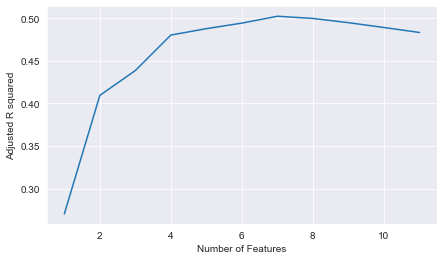

In [34]:
r_squared_best = []
for k, v in best_results.items():
    r_squared_best.append(v[0])
    print(v[0], v[1])
    
print()
plt.figure(figsize=(7,4))
plt.plot(range(1, len(r_squared_best)+1), r_squared_best);
plt.xlabel("Number of Features")
plt.ylabel("Adjusted R squared");

In [35]:
def print_best_results(d, n=1):
    print("Features used:", d[n][1])
    print("\nAdjusted R-squared:", d[n][0])
    print("\nP-values for coefficients:\n", d[n][2])
    
print_best_results(best_results, n=4)

Features used: ('AGE', 'FEV1', 'HAD', 'AtrialFib')

Adjusted R-squared: 0.4803322382670018

P-values for coefficients:
 Intercept    1.109453e-10
AGE          4.187619e-03
FEV1         2.701691e-05
HAD          2.115271e-03
AtrialFib    1.230367e-07
dtype: float64


##### Multiple Linear Regression with Selected Features Using Cross-validation

In [36]:
selected_features = ['AGE', 'FEV1', 'HAD', 'AtrialFib']
df_model = df[selected_features]
df_model = add_poly(df_model, selected_features, degree=2, interaction_only=True)
scale_features = [x for x in df_model.columns if df_model[x].max() > 1]
df_norm = normalize(df_model, scale_features)
df_norm.head()

,AGE,FEV1,HAD,AtrialFib,AGE*FEV1,AGE*HAD,AGE*AtrialFib,FEV1*HAD,FEV1*AtrialFib,HAD*AtrialFib
0,0.878158,-0.584483,-0.363993,1,-0.401465,-0.258937,2.176637,-0.451138,1.517035,0.832607
1,1.133481,-0.762891,1.155990,1,-0.552354,1.551903,2.246148,0.377091,1.322304,2.843049
2,1.261143,-0.123594,0.805224,1,0.206153,1.171679,2.280904,0.657347,2.020091,2.379101
3,-1.802738,-1.684668,1.740598,1,-1.830211,1.199458,1.446761,-0.291887,0.316192,3.616296
4,-0.653783,-0.792626,0.805224,0,-0.906281,0.702909,-0.499573,0.149500,-0.446505,-0.404588


##### Ridge Regression with Built-in Cross-validation

In [37]:
alphas = [1e-3, 1e-2, 1e-1, 1, 10, 20, 50, 100, 200]
rr = RidgeCV(alphas=alphas, cv=8).fit(df_norm, df[target])
rr_r2 = rr.score(df_norm, df[target])

##### Lasso Regression with Built-in Cross-validation

In [38]:
ls = LassoCV(cv=8).fit(df_norm, df[target].values.ravel())
ls_r2 = ls.score(df_norm, df[target].values.ravel())
print("Number of non-zero coefficients:", len(ls.coef_.nonzero()[0]))

Number of non-zero coefficients: 5


##### ElasticNet Regression with Built-in Cross-validation

In [39]:
en = ElasticNetCV(cv=8).fit(df_norm, df[target].values.ravel())
en_r2 = en.score(df_norm, df[target].values.ravel())

In [40]:
labels = ["Linear", "Ridge", "Lasso", "ElasticNet"]
r2_values = [best_results[4][0], rr_r2, ls_r2, en_r2]
r2_df = pd.Series(r2_values, index=labels).to_frame()
r2_df.rename(columns={0:"R-squared"}, inplace=True)
r2_df

,R-squared
Linear,0.480332
Ridge,0.462688
Lasso,0.508886
ElasticNet,0.508469


### Model Summary

Features that were strongly correlated with each other, e.g., `FEV1` and `FEVPRED` were not selected both. In addition, several features such as `CAT` implicitely contain information with regards to the outcome variable (`MWT1Best`) and were therefore omitted from the analysis. One goal of developing the model was to be able to relate the regression coefficients to actual patients with or without (a set of) condition(s) and, as such, only interaction terms, i.e., no higher order terms, were included in the analysis. Moreover, interaction terms were only generated for interaction between selected binary predictors.

Numeric features that were non-binary (e.g. continuous) were scaled by subtracting the mean and scaling to unit variance. Note that feature normalization is not strictly necessary for a "regular" linear regression but is required when performed ridge or lasso regression.

Given the limited number of observations, cross-validation was used to asses how the model would generalize to an independent data set instead of using a train-test split.

Using the adjusted R-squared value to assess the predictive ability of the model using different numbers of features (without interaction terms), it could be seen that the most important features were `AGE`, `FEV1`, `HAD`, and `AtrialFib` with an adjusted R-squared value of approximately 0.48. The addition of additional features did not seem to increase the R-squared value significantly.  

In addition, performing either a Ridge, Lasso, or ElasticNet regression with interaction features and cross-validation did not significantly improve the R-squared value. The model recommended for further use is the multiple regression model using `AGE`, `FEV1`, `HAD`, and `AtrialFib` as predictors of `MWT1Best` given it is the simplest (no interaction features) and can readily be interpreted.

### Next Steps  

The acquisition of more data would definitely help build a better model. The current model is based on only 99 observations and, as such, it may it not be representative of the true population from which the current sample is derived.  In addition, the current model is based on the outcome `MWT1Best`, which represents the best of two walking distance measurements. It is not inconceivable that another feature, such as `SGRQ`, could lead to a regression model with a higher adjusted R-squared value.